In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
import scanpy as sc
# import scvelo as scv

# read the full GSE dataset
data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/Stuart_GSE128639/Stuart_bm_v2.h5ad')
data.shape

(30011, 17009)

In [3]:
### Raw counts were not normalizaed
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [4]:
# data.obs['celltype.l1'] = data.obs['celltype.l1'].str.replace(' ', '_')

label = data.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
# types = [s.replace(' ', '_') for s in types]
print(types)

['B_cell', 'Mono&DC', 'NK', 'Progenitor_cells', 'T_cell']


## Cell count for each type

In [11]:
data.obs['celltype.l1'].value_counts()

T_cell              14566
Mono&DC              7658
B_cell               3733
Progenitor_cells     2678
NK                   1376
Name: celltype.l1, dtype: int64

## Read features

In [5]:
# Level 1 ADlasso features by loss difference convergence
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/Stuart_bm/Level1_onlylog1p/feature_selection')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [7]:
features_dict['B_cell'].head()

,Gene,Weight,Tendency
0,CD52,0.485839,1
1,TMSB10,-0.231432,0
2,IGKC,0.588110,1
3,CD74,1.350799,1
4,LTB,0.219740,1


In [6]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B_cell,16,8
Mono&DC,20,8
NK,13,3
Progenitor_cells,33,23
T_cell,29,16


## Get likelihood from LR model

In [8]:
def LR_likelihood(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    decision_scores = clf.decision_function(X)  # >0: predict celltype, <0: predict not celltype
    print('decision_scores > 0:', sum(decision_scores > 0))  # decision_scores > 0 的有幾個

    ### calculate the likelihood of the positive class for each observation in X based on the decision scores
    likelihood = 1 / (1 + np.exp(-decision_scores))
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # >0.5: predict celltype, <0.5: predict not celltype
    print(type(likelihood), likelihood.shape)
    #do the row-wise softmax
    # likelihood = np.exp(likelihood)/np.sum(np.exp(likelihood),1,keepdims=True)
    
    # likelihood is a 1-D array with the same length as the number of cells
    return likelihood


In [9]:
celltype = 'B_cell'  # original 3733 B cells
B_likelihood = LR_likelihood(data, features_dict, celltype)
B_likelihood.shape

Celltype: B_cell
decision_scores > 0: 3720
likelihood > 0.5: 3720
<class 'numpy.ndarray'> (30011,)


(30011,)

In [12]:
likelihood_dict = {}
for celltype in types:
    likelihood_dict[celltype] = LR_likelihood(data, features_dict, celltype)

Celltype: B_cell
decision_scores > 0: 3720
likelihood > 0.5: 3720
<class 'numpy.ndarray'> (30011,)
Celltype: Mono&DC
decision_scores > 0: 7693
likelihood > 0.5: 7693
<class 'numpy.ndarray'> (30011,)
Celltype: NK
decision_scores > 0: 1362
likelihood > 0.5: 1362
<class 'numpy.ndarray'> (30011,)
Celltype: Progenitor_cells
decision_scores > 0: 2533
likelihood > 0.5: 2533
<class 'numpy.ndarray'> (30011,)
Celltype: T_cell
decision_scores > 0: 14594
likelihood > 0.5: 14594
<class 'numpy.ndarray'> (30011,)


In [13]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
print(likelihood_df.shape)
likelihood_df.head()

(30011, 5)


,B_cell,Mono&DC,NK,Progenitor_cells,T_cell
0,5.508213e-04,2.458989e-03,0.000012,0.998093,0.015331
1,4.149614e-07,1.106687e-03,0.000187,0.000512,0.998783
2,2.756064e-06,7.827886e-07,0.000089,0.000096,0.998951
3,4.664967e-03,5.042658e-04,0.000008,0.000110,0.999280
4,6.815213e-04,9.952050e-01,0.000031,0.018804,0.000041


In [14]:
# row sum
likelihood_df.sum(axis=1)


0        1.016446
1        1.000589
2        0.999140
3        1.004567
4        1.014762
           ...   
30006    1.023630
30007    1.000222
30008    1.000056
30009    1.001151
30010    1.007043
Length: 30011, dtype: float64

In [16]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/Stuart_bm/Level1_onlylog1p/LR_likelihood')
likelihood_df.to_csv('L1_likelihood_df.csv')

### 20231227: add softmax operation to likelihood, poor result

In [17]:
# Applying row-wise softmax
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

likelihood_softmax = pd.DataFrame(softmax(likelihood_df.values), columns=likelihood_df.columns)
likelihood_softmax.shape

(30011, 5)

## Odds ratio: (1st_type / 2nd_type) >= 1.5

In [19]:
largest_values = []
second_largest_values = []
largest_columns = []
second_largest_columns = []
odds_ratio_list = []
assignments = []

# for index, row in likelihood_softmax.iterrows():
for index, row in likelihood_df.iterrows():
    # find 1st and 2nd largest values and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    second_largest_value = row.nlargest(2).iloc[-1]
    second_largest_column = row.nlargest(2).index[-1]
    
    largest_values.append(largest_value)
    second_largest_values.append(second_largest_value)
    largest_columns.append(largest_column)
    second_largest_columns.append(second_largest_column)

    # calculate odds ratio
    odds_ratio = largest_value / second_largest_value
    if odds_ratio >= 1.5:
        assign = largest_column
    else:
        assign = 'Uncertain'
    odds_ratio_list.append(odds_ratio)
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns,
                          'Second Largest Value': second_largest_values, 'Second Largest Column': second_largest_columns, 
                          'Odds Ratio': odds_ratio_list, 'Assignment': assignments})
result_df.shape


(30011, 6)

In [20]:
result_df.head(20)

,Largest Value,Largest Column,Second Largest Value,Second Largest Column,Odds Ratio,Assignment
0,0.998093,Progenitor_cells,0.015331,T_cell,65.102567,Progenitor_cells
1,0.998783,T_cell,0.001107,Mono&DC,902.498227,T_cell
2,0.998951,T_cell,0.000096,Progenitor_cells,10394.825267,T_cell
3,0.999280,T_cell,0.004665,B_cell,214.209480,T_cell
4,0.995205,Mono&DC,0.018804,Progenitor_cells,52.925640,Mono&DC
5,0.953161,B_cell,0.011695,Progenitor_cells,81.499834,B_cell
6,0.991157,T_cell,0.000525,Mono&DC,1889.359522,T_cell
7,0.988900,Mono&DC,0.005964,Progenitor_cells,165.810927,Mono&DC
8,0.996466,B_cell,0.049554,T_cell,20.108860,B_cell
9,0.999995,T_cell,0.009007,Progenitor_cells,111.021709,T_cell


In [21]:
sum(result_df['Assignment'] == 'Uncertain')

686

In [22]:
686/len(result_df)

0.02285828529539169

## Confusion heatmap

In [24]:
import pandas as pd

# Get the true labels
true_labels = data.obs['celltype.l1'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# reorder columns
cm = cm.reindex(types + ['Uncertain'], axis=1)

# replace NaN with 0
cm = cm.fillna(0)
cm = cm.astype(int)


In [25]:
cm.shape

(5, 6)

In [26]:
cm

Predicted,B_cell,Mono&DC,NK,Progenitor_cells,T_cell,Uncertain
True,,,,,,
B_cell,3597,11,1,14,18,92
Mono&DC,21,7454,1,68,3,111
NK,2,11,1146,5,73,139
Progenitor_cells,39,104,4,2275,19,237
T_cell,2,10,31,9,14407,107


In [29]:
# export confusion matrix
cm.to_csv('L1_OR_confusion_matrix.csv')

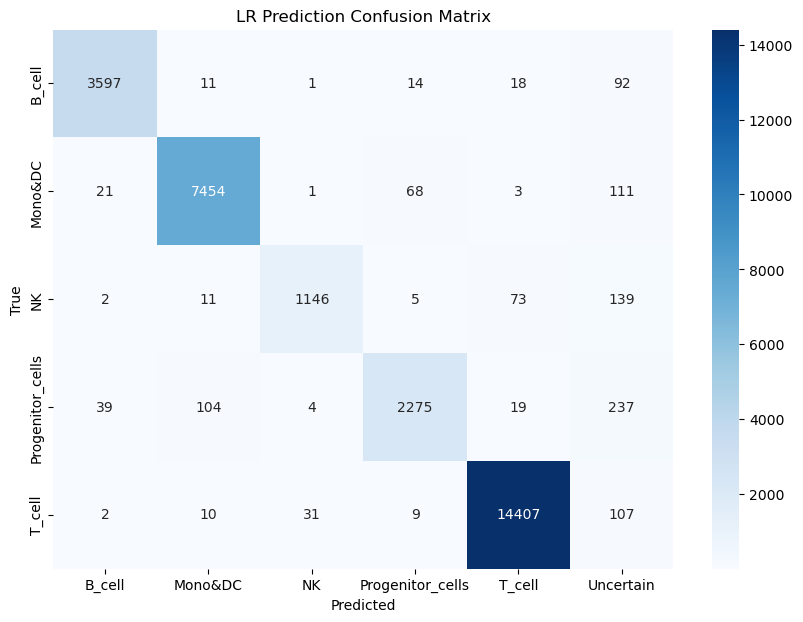

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [31]:
row_sum = cm.sum(axis=1)
row_sum


True
B_cell               3733
Mono&DC              7658
NK                   1376
Progenitor_cells     2678
T_cell              14566
dtype: int64

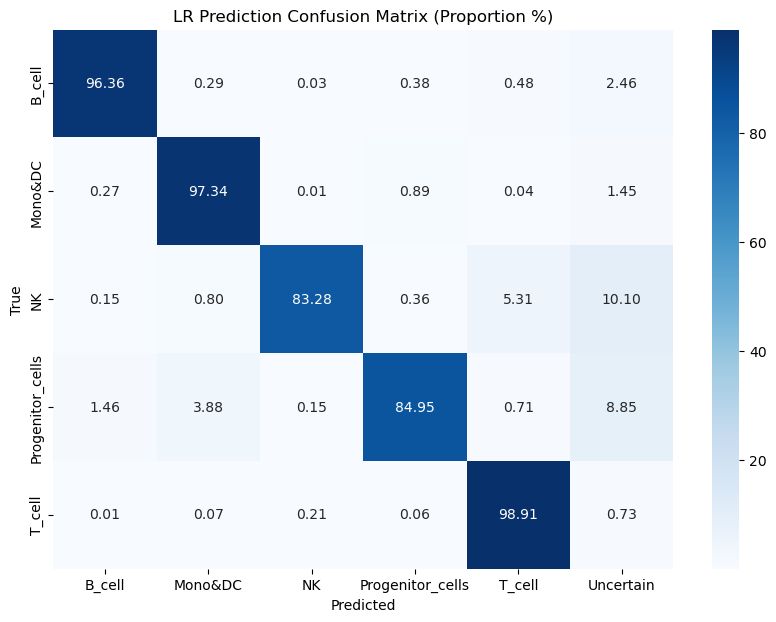

In [32]:
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(10, 7))
sns.heatmap(cm_proportion, fmt=".2f", annot=True, cmap='Blues')
plt.title('LR Prediction Confusion Matrix (Proportion %)')
plt.show()

## Calculate accuracy

In [33]:
accuracy = sum(np.diag(cm)) / cm.values.sum()
accuracy

0.9622804971510446

In [34]:
cm.values.sum()

30011

## Use predict_proba to calculate likelihood

In [62]:
def new_LR_likelihood(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # likelihood of the positive class for each observation
    likelihood = clf.predict_proba(X)[:, 1]  # >0.5: predict celltype, <0.5: predict not celltype
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # decision_scores > 0 的有幾個

    return likelihood


In [59]:
celltype = 'B_cell'
likelihood = new_LR_likelihood(data, features_dict, celltype)

Celltype: B_cell


In [61]:
sum(likelihood >= 0.5)

3720

In [63]:
likelihood_dict = {}
for celltype in types:
    likelihood_dict[celltype] = new_LR_likelihood(data, features_dict, celltype)

Celltype: B_cell
likelihood > 0.5: 3720
Celltype: Mono&DC
likelihood > 0.5: 7693
Celltype: NK
likelihood > 0.5: 1362
Celltype: Progenitor_cells
likelihood > 0.5: 2533
Celltype: T_cell
likelihood > 0.5: 14594


In [66]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
print(likelihood_df.shape)
likelihood_df.head()

(30011, 5)


,B_cell,Mono&DC,NK,Progenitor_cells,T_cell
0,5.508213e-04,2.458989e-03,0.000012,0.998093,0.015331
1,4.149614e-07,1.106687e-03,0.000187,0.000512,0.998783
2,2.756064e-06,7.827886e-07,0.000089,0.000096,0.998951
3,4.664967e-03,5.042658e-04,0.000008,0.000110,0.999280
4,6.815213e-04,9.952050e-01,0.000031,0.018804,0.000041


In [65]:
# row sum
likelihood_df.sum(axis=1)


0        1.016446
1        1.000589
2        0.999140
3        1.004567
4        1.014762
           ...   
30006    1.023630
30007    1.000222
30008    1.000056
30009    1.001151
30010    1.007043
Length: 30011, dtype: float64

In [67]:
largest_values = []
second_largest_values = []
largest_columns = []
second_largest_columns = []
odds_ratio_list = []
assignments = []

# for index, row in likelihood_softmax.iterrows():
for index, row in likelihood_df.iterrows():
    # find 1st and 2nd largest values and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    second_largest_value = row.nlargest(2).iloc[-1]
    second_largest_column = row.nlargest(2).index[-1]
    
    largest_values.append(largest_value)
    second_largest_values.append(second_largest_value)
    largest_columns.append(largest_column)
    second_largest_columns.append(second_largest_column)

    # calculate odds ratio
    odds_ratio = largest_value / second_largest_value
    if odds_ratio >= 1.5:
        assign = largest_column
    else:
        assign = 'Uncertain'
    odds_ratio_list.append(odds_ratio)
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns,
                          'Second Largest Value': second_largest_values, 'Second Largest Column': second_largest_columns, 
                          'Odds Ratio': odds_ratio_list, 'Assignment': assignments})
result_df.shape


(30011, 6)

In [68]:
result_df.head(20)

,Largest Value,Largest Column,Second Largest Value,Second Largest Column,Odds Ratio,Assignment
0,0.998093,Progenitor_cells,0.015331,T_cell,65.102567,Progenitor_cells
1,0.998783,T_cell,0.001107,Mono&DC,902.498227,T_cell
2,0.998951,T_cell,0.000096,Progenitor_cells,10394.825267,T_cell
3,0.999280,T_cell,0.004665,B_cell,214.209480,T_cell
4,0.995205,Mono&DC,0.018804,Progenitor_cells,52.925640,Mono&DC
5,0.953161,B_cell,0.011695,Progenitor_cells,81.499834,B_cell
6,0.991157,T_cell,0.000525,Mono&DC,1889.359522,T_cell
7,0.988900,Mono&DC,0.005964,Progenitor_cells,165.810927,Mono&DC
8,0.996466,B_cell,0.049554,T_cell,20.108860,B_cell
9,0.999995,T_cell,0.009007,Progenitor_cells,111.021709,T_cell


In [69]:
sum(result_df['Assignment'] == 'Uncertain')

686

In [70]:
686/len(result_df)

0.02285828529539169

In [71]:
import pandas as pd

# Get the true labels
true_labels = data.obs['celltype.l1'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# reorder columns
cm = cm.reindex(types + ['Uncertain'], axis=1)

# replace NaN with 0
cm = cm.fillna(0)
cm = cm.astype(int)


In [72]:
cm

Predicted,B_cell,Mono&DC,NK,Progenitor_cells,T_cell,Uncertain
True,,,,,,
B_cell,3597,11,1,14,18,92
Mono&DC,21,7454,1,68,3,111
NK,2,11,1146,5,73,139
Progenitor_cells,39,104,4,2275,19,237
T_cell,2,10,31,9,14407,107


In [74]:
row_sum = cm.sum(axis=1)
row_sum


True
B_cell               3733
Mono&DC              7658
NK                   1376
Progenitor_cells     2678
T_cell              14566
dtype: int64

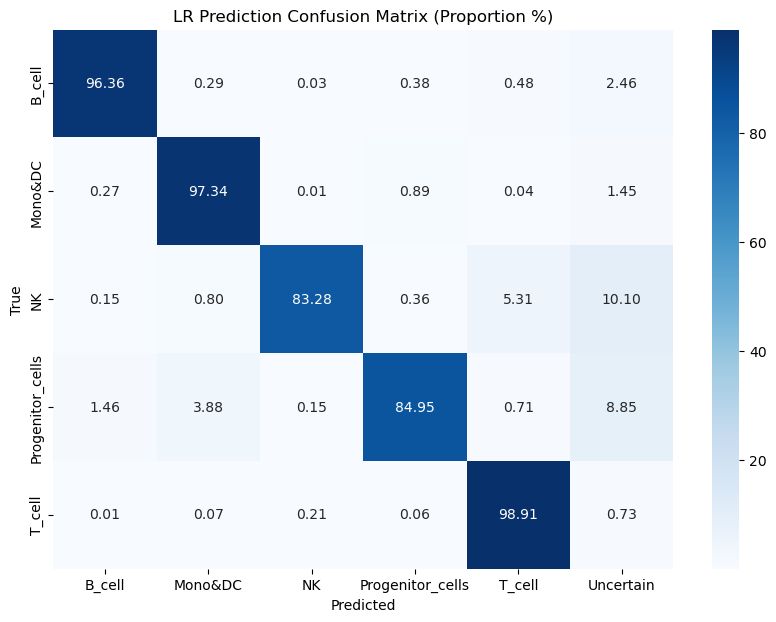

In [75]:
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(10, 7))
sns.heatmap(cm_proportion, fmt=".2f", annot=True, cmap='Blues')
plt.title('LR Prediction Confusion Matrix (Proportion %)')
plt.show()

## Calculate accuracy

In [76]:
accuracy = sum(np.diag(cm)) / cm.values.sum()
accuracy

0.9622804971510446

In [77]:
cm.values.sum()

30011